In [1]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

# from tensorflow.keras import models,layers,preprocessing as kprocessing
# from tensorflow.keras import backend as K

# import transformers

import numpy as np

/home/ubuntu/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [3]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [4]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [5]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. 
**** NEED to remove that in AWS

In [6]:
# df = get_samples(df,100000)

In [7]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [8]:
df.shape

(1400000, 4)

In [9]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer

In [10]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...,why doesn't an optical mouse work on a glass t...,why doesn't an optical mouse work on a glass t...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,What is the best off-road motorcycle trail ?lo...,What is the best off-road motorcycle trail ?lo...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,What is Trans Fat? How to reduce that?I heard ...,What is Trans Fat? How to reduce that?I heard ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...,How many planes Fedex has?I heard that it is t...,How many planes Fedex has?I heard that it is t...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...,"In the san francisco bay area, does it make se...","In the san francisco bay area, does it make se..."


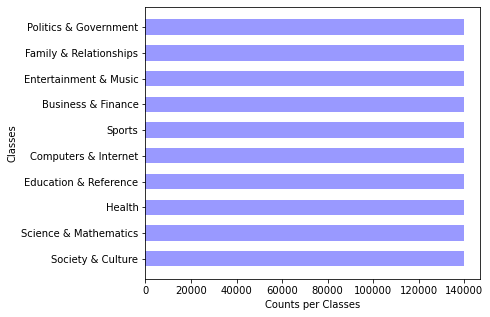

In [11]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [12]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [13]:
lst_stopwords = stopwords.words('english')

In [14]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [15]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [16]:
df.head(10)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...,why doesn't an optical mouse work on a glass t...,why doesn't an optical mouse work on a glass t...,optical mouse work glass table even surface op...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,What is the best off-road motorcycle trail ?lo...,What is the best off-road motorcycle trail ?lo...,best road motorcycle trail long distance trail...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,What is Trans Fat? How to reduce that?I heard ...,What is Trans Fat? How to reduce that?I heard ...,trans fat reduce heard tras fat bad body find ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...,How many planes Fedex has?I heard that it is t...,How many planes Fedex has?I heard that it is t...,many plane fedex heard largest airline worldac...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...,"In the san francisco bay area, does it make se...","In the san francisco bay area, does it make se...",san francisco bay area make sense rent buy pri...
5,5,What's the best way to clean a keyboard?,I have very small stuff stuck under my keyboar...,"There are commercial kits available, but a can...",What's the best way to clean a keyboard?I have...,What's the best way to clean a keyboard?I have...,best way clean keyboard small stuff stuck keyb...
6,2,Why do people blush when they are embarrassed?,Why do people blush when they are embarrassed?,from ask yahoo...\nhttp://ask.yahoo.com/ask/20...,Why do people blush when they are embarrassed?...,Why do people blush when they are embarrassed?...,people blush embarrassed people blush embarras...
7,8,"Is Lin Qingxia (aka Brigitte Lin) ""the most be...",This is according to Stephen Chow (http://www....,Well. Everyone has different definition on wh...,"Is Lin Qingxia (aka Brigitte Lin) ""the most be...","Is Lin Qingxia (aka Brigitte Lin) ""the most be...",lin qingxia aka brigitte lin beautiful woman c...
8,5,"What is the origin of ""foobar""?",I want to know the meaning of the word and how...,"Not sure if this is the origin, but I think it...","What is the origin of ""foobar""?I want to know ...","What is the origin of ""foobar""?I want to know ...",origin foobar want know meaning word explain f...
9,2,How the human species evolved?,How the human species evolved?,A tough question as it overlaps science and th...,How the human species evolved?How the human sp...,How the human species evolved?How the human sp...,human specie evolved human specie evolved toug...


In [17]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [18]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...,why doesn't an optical mouse work on a glass t...,why doesn't an optical mouse work on a glass t...,optical mouse work glass table even surface op...,149,749,7,5.026846,21.285714
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,What is the best off-road motorcycle trail ?lo...,What is the best off-road motorcycle trail ?lo...,best road motorcycle trail long distance trail...,22,124,2,5.636364,11.000000


In [19]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

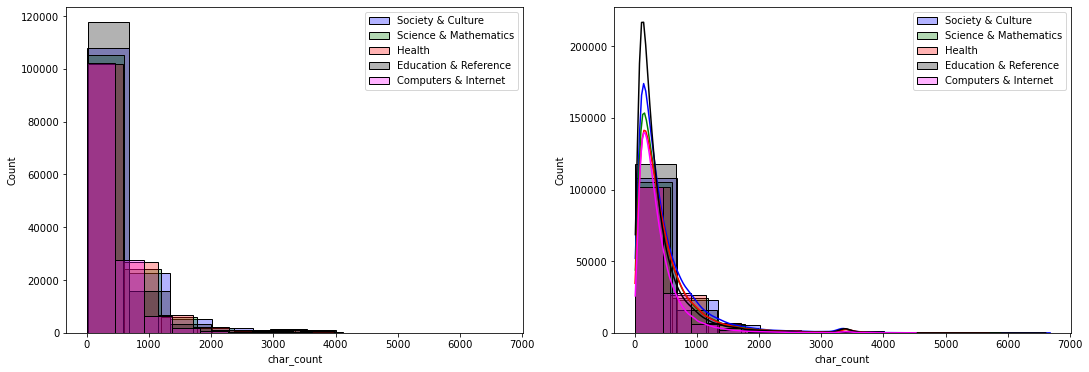

In [20]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [21]:
df.groupby('target').word_count.median()

target
1     71
2     66
3     75
4     52
5     59
6     45
7     53
8     41
9     75
10    73
Name: word_count, dtype: int64

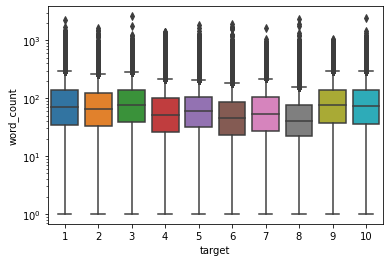

In [22]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

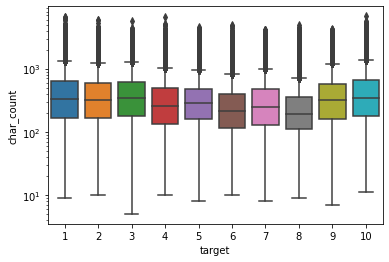

In [23]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

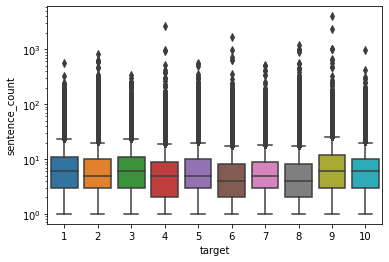

In [24]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

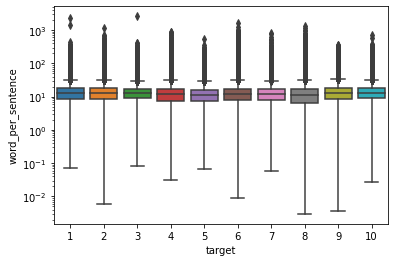

In [25]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [26]:
X = df.Text_new
y = df.target

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [28]:
vect = TfidfVectorizer(max_features=10000,ngram_range=(1,2))

In [29]:
vect.fit(X_train)

TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [30]:
# X_train is the raw data
# XX_train is the matrix based on the X_train
XX_train = vect.transform(X_train)

In [31]:
vocab = vect.vocabulary_

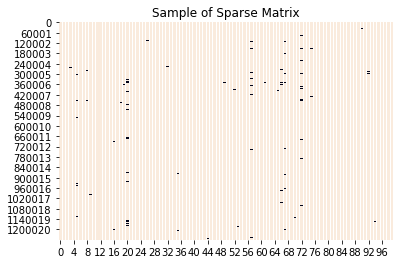

In [32]:
sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [34]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    df_features = df_features.sort_values(["y","Score"],ascending=[True,False])
    df_features = df_features[df_features.Score>0.95]

X_names_unique = df_features.feature.unique().tolist()

In [35]:
df_features.head(5)

,feature,Score,y
137,2006,1.0,1
162,2x,1.0,1
298,abortion,1.0,1
299,abraham,1.0,1
316,accent,1.0,1


In [37]:
for category in np.unique(y_train):
    print(f'category {category}:',target_classes[category-1])
    print(f'length of category {category}:',len(df_features[df_features.y==category]))
    print(",".join(df_features[df_features.y==category].feature[:20]))
    print("")

category 1: Society & Culture
length of category 1: 6342
2006,2x,abortion,abraham,accent,accept,acceptable,accepted,accepting,access,according,account,acid,acknowledge,act,adam,adam eve,address,adultery,african

category 2: Science & Mathematics
length of category 2: 7756
000,000 000,000 year,10,10 10,100,1000,11,12,12 12,120,125,14,15,16,180,20,200,2006,22

category 3: Health
length of category 3: 7179
000,10 day,10 minute,140,15 minute,20,20 minute,2006,24 hour,2x,30,30 minute,ab,abdomen,abdominal,abnormal,access,account,ache,acid

category 4: Education & Reference
length of category 4: 5457
10th,12,12th,2x,3x,4x,5x,6x,8th,8th grade,abbreviation,abroad,academic,academy,accepted,account,accounting,accredited,achievement,acronym

category 5: Computers & Internet
length of category 5: 8252
000,11,12,128,13,14,15,16,168,18,192,20,2000,2003,256,2x,3000,360,3d,512

category 6: Sports
length of category 6: 7533
06,07,1930,1950,1962,1966,1970,1972,1974,1975,1976,1978,1979,1980,1982,1983,1984

In [38]:
vect = TfidfVectorizer(vocabulary=X_names_unique)

In [39]:
vect.fit(X_train)

TfidfVectorizer(vocabulary=['2006', '2x', 'abortion', 'abraham', 'accent',
                            'accept', 'acceptable', 'accepted', 'accepting',
                            'access', 'according', 'account', 'acid',
                            'acknowledge', 'act', 'adam', 'adam eve', 'address',
                            'adultery', 'african', 'african american',
                            'agnostic', 'agree', 'air', 'album', 'alive',
                            'allah', 'almighty', 'also believe', 'always', ...])

In [40]:
# X_train is the raw data
# XX_train is the matrix based on the X_train
XX_train = vect.transform(X_train)

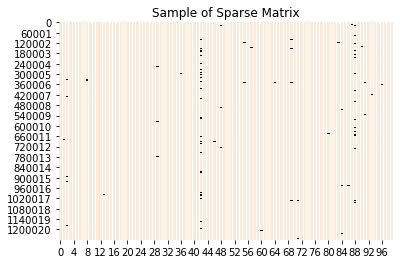

In [42]:
sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [43]:
# Creating a cloud of words

In [44]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

In [45]:
Text = " ".join(df_features[df_features.y==7].feature[:20])
Text

'00 000 000 00 10 000 100 000 12 month 2x 30 day 401k 500 800 account accountant accounting acid ad address adsense advertise advertisement'

In [46]:
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

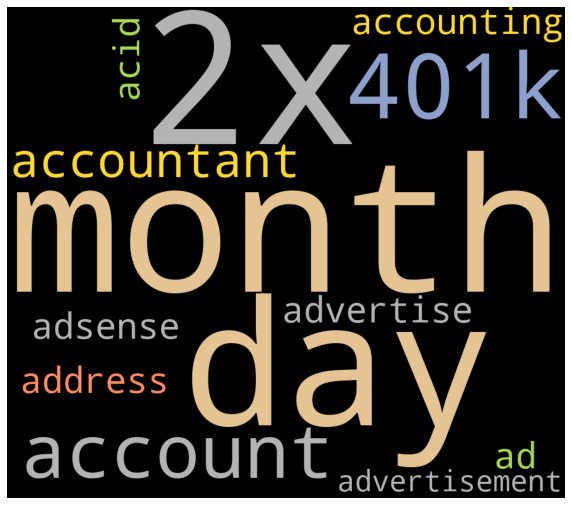

In [47]:
plot_cloud(wordcloud)

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [48]:
nb = naive_bayes.MultinomialNB()

In [49]:
# pipeline
model = pipeline.Pipeline([("vectorizer",vect),
                           ("classifier",nb)])

In [50]:
cross_val_score(model,X_train,y_train,cv=5,n_jobs=-1)

array([0.67692063, 0.67819444, 0.6799127 , 0.67823413, 0.68005556])

In [51]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(vocabulary=['2006', '2x', 'abortion',
                                             'abraham', 'accent', 'accept',
                                             'acceptable', 'accepted',
                                             'accepting', 'access', 'according',
                                             'account', 'acid', 'acknowledge',
                                             'act', 'adam', 'adam eve',
                                             'address', 'adultery', 'african',
                                             'african american', 'agnostic',
                                             'agree', 'air', 'album', 'alive',
                                             'allah', 'almighty',
                                             'also believe', 'always', ...])),
                ('classifier', MultinomialNB())])

In [52]:
## Test Classifier
Predicted = model.predict(X_test)
Predicted_prob = model.predict_proba(X_test)

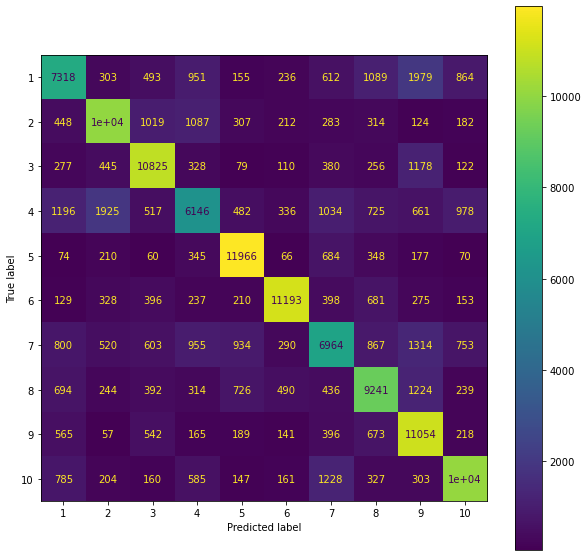

In [53]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model,X_test,y_test,ax=ax);

### Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [54]:
lr = LogisticRegression(max_iter=5000)

In [55]:
# pipeline
model_lr = pipeline.Pipeline([("vectorizer",vect),
                           ("classifier",lr)])

In [56]:
cross_val_score(model_lr,X_train,y_train,cv=5,n_jobs=-1)

array([0.70223016, 0.70178571, 0.70317063, 0.70300397, 0.7045119 ])

In [57]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(vocabulary=['2006', '2x', 'abortion',
                                             'abraham', 'accent', 'accept',
                                             'acceptable', 'accepted',
                                             'accepting', 'access', 'according',
                                             'account', 'acid', 'acknowledge',
                                             'act', 'adam', 'adam eve',
                                             'address', 'adultery', 'african',
                                             'african american', 'agnostic',
                                             'agree', 'air', 'album', 'alive',
                                             'allah', 'almighty',
                                             'also believe', 'always', ...])),
                ('classifier', LogisticRegression(max_iter=5000))])

In [58]:
## Test Classifier
Predicted = model_lr.predict(X_test)
Predicted_prob = model_lr.predict_proba(X_test)

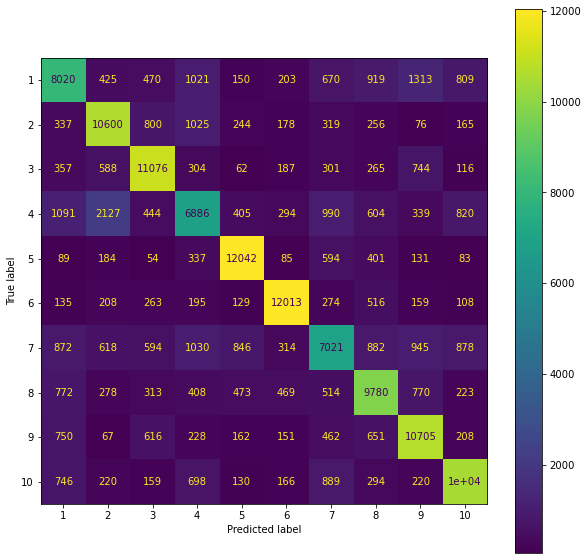

In [59]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,X_test,y_test,ax=ax);

### Random Forest Classifier
In this section, we will use random forest classiier to fit our model to the training dataset

In [65]:
rf = RandomForestClassifier(n_estimators=1000,n_jobs=-1)

In [66]:
# pipeline
model_rf = pipeline.Pipeline([("vectorizer",vect),
                              ("classifier",rf)])

In [ ]:
cross_val_score(model_rf,X_train,y_train,cv=5,n_jobs=-1)

In [63]:
classes = np.unique(y_test)
y_test_dummy = pd.get_dummies(y_test).values

accuracy = accuracy_score(y_test,Predicted)
auc = roc_auc_score(y_test,Predicted_prob,multi_class='ovr')

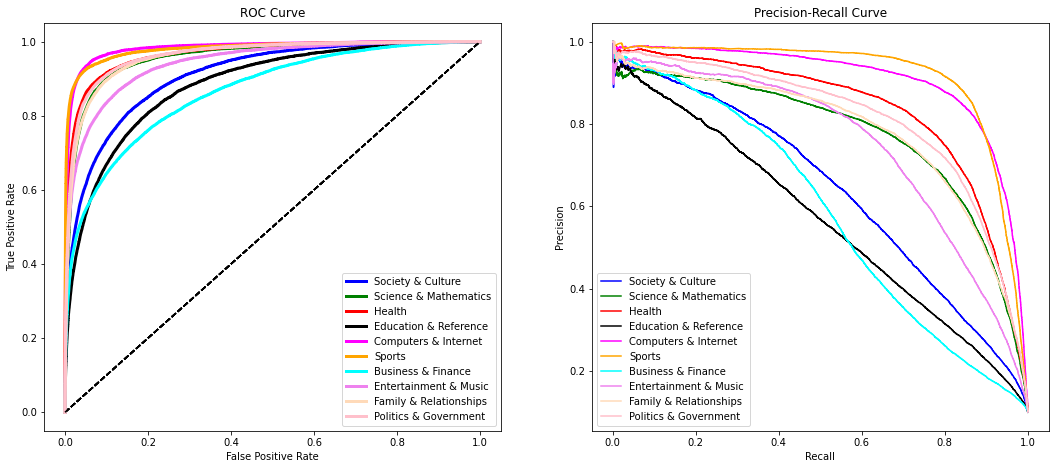

In [64]:
fig,axs = plt.subplots(1,2,figsize=(18,7.5))
for i in range(10):
    # ROC Curve
    fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[0].plot(fpr,tpr,lw=3,label=target_classes[i],color=colors[i])
    axs[0].plot([0,1],[0,1],color='k',ls='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()
    axs[0].set_title('ROC Curve')
    # Precision-Recall Curve
    precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[1].plot(recall,precision,label=target_classes[i],color=colors[i])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend()
    

In [ ]:
# Testing the error
# X_test[y_test!=Predicted].iloc[1]
# y_test[y_test!=Predicted]
# Predicted[y_test!=Predicted]


### USE THE BELOW LINES FOR DEBUGGING

In [ ]:
# test_set = 20
# text = X_test.iloc[test_set]
# text

In [ ]:
# print('Actual class -->',y_test.iloc[test_set],'|     Predicted class is -->',Predicted[test_set],
#       '|     Probability -->  ',np.max(Predicted_prob[test_set]))
# print('Actual class -->',target_classes[y_test.iloc[test_set]-1])
# print('Predicted class -->',target_classes[Predicted[test_set]-1])

In [ ]:
# # explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
# explainer = lime_text.LimeTextExplainer(class_names=target_classes)

In [ ]:
# explained = explainer.explain_instance(text,model.predict_proba,num_features=3,top_labels=1)

In [ ]:
# explained.show_in_notebook(text=text,predict_proba=True)

In [ ]:
s = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", s)

In [ ]:
s = re.sub(" \d+", " ", s)